# Graded Exercise 1: Extraction of Discriminative Features for Anomaly Detection on Acoustic Data

- **Course**: [CIVIL-426 - Machine Learning for Predictive Maintenance](https://edu.epfl.ch/coursebook/en/machine-learning-for-predictive-maintenance-applications-CIVIL-426)
- **Start Date**: 2024.09.19 at 10h15
- **Due Date**: 2024.10.02 at 23h59
- **Student 0**:
    - First and Last name: Sophea Bonne
    - SCIPER: 352901

- **Student 1**:
    - First and Last name: Joshua Cohen-Dumani
    - SCIPER: 311105

## Introduction

This notebook is divided in 2 parts:
- [Part 0](#part-0-demonstration): Demonstration on a toy dataset

This part shows how to extract discriminative features for anomaly detection on a toy 
dataset. This part of the notebook runs without any issues on a properly configured 
machine. You are **not** expected to fill anything in this part.

- [Part 1](#part-1-exercise): Graded exercise

This part contains the detailed questions and assignments of the graded exercise. You
are expected to fill this part with your own code and your own answers to the questions.

⚠️ The deadline to hand-in a PDF report along this complete notebook with 
[Part 1](#part-1-exercise) filled is **October 2nd, 2024 at 23h59**. No submissions 
will be accepted past this deadline. ⚠️

---

## Part 0: Demonstration

### 0. Introduction

The **goals** of this exercise are:

* Extracting statistical features of acoustic signals to discriminate between normal and abnormal samples
* Defining a threshold-based anomaly detection rule based on normal samples only

The **requirements** are:
* Your method can use a single feature or a combination of features
* You must include visualization in a meaningful way
* Your method must be developed based on the **TRAIN set** only

This part contains an example on a toy dataset.

1. **Train**: training set containing only healthy (normal) samples
2. **Test**: test set containing both normal and abnormal samples.

### 1. Notebook Configuration

In [1]:
# Packages for visualization
%pip install seaborn matplotlib-venn --upgrade --quiet
# Packages for feature extraction and machine learning
%pip install librosa numpy pandas scipy --upgrade --quiet


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import librosa
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import numpy as np
from numpy.fft import fft
import pandas as pd
import seaborn as sns
import scipy.stats as scist

# Matplotlib configuration for notebooks
%matplotlib inline


### 2. Load the Dataset 

In [3]:
# Load the dataset from your disk (you must have downloaded the file)
data = np.load("toy_data.npz")

# Extract the training and testing set
train_set = data["train"]
test_set = data["test"]

train_set_size = train_set.shape[0]
train_set_timesteps = train_set.shape[1]
test_set_size = test_set.shape[0]
test_set_timesteps = test_set.shape[1]


In [4]:
# About the train dataset
print(
    f"The TRAINING set contains {train_set_size} recordings. "
    f"Each recording contains {train_set_timesteps} samples."
)

# About the test dataset
print(
    f"The TESTING set contains {test_set_size} recordings. "
    f"Each recording contains {test_set_timesteps} samples."
)


The TRAINING set contains 500 recordings. Each recording contains 1000 samples.
The TESTING set contains 200 recordings. Each recording contains 1000 samples.


### 3. Visual Signals

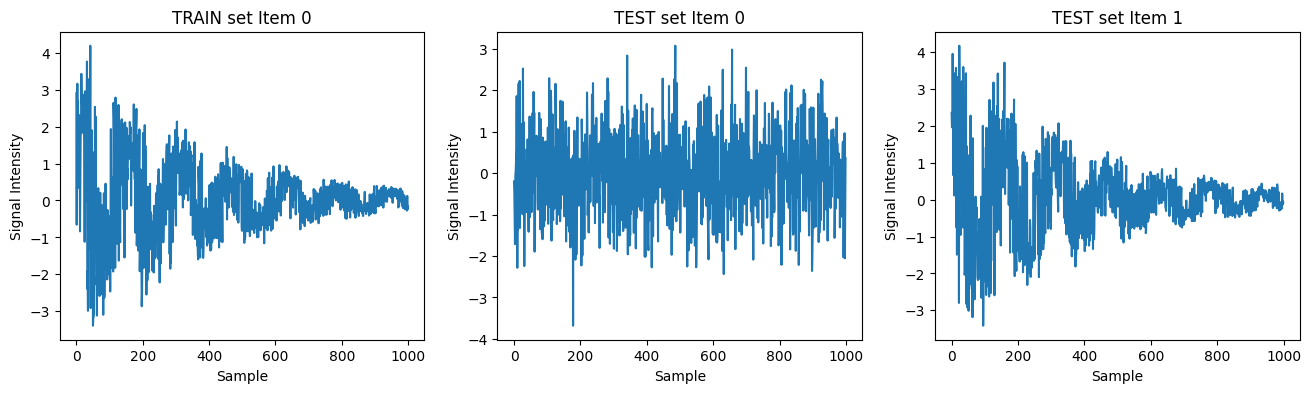

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].plot(train_set[0])
ax[0].set_title("TRAIN set Item 0")
ax[1].plot(test_set[0])
ax[1].set_title("TEST set Item 0")
ax[2].plot(test_set[1])
ax[2].set_title("TEST set Item 1")

for i in range(3):
    ax[i].set_xlabel("Sample")
    ax[i].set_ylabel("Signal Intensity")


### 4. Compute Absolute Values

In [6]:
train_set_abs = np.abs(train_set)
test_set_abs = np.abs(test_set)


### 5. Compute Min, Max, Centered Moments and Centralized Moments

In [7]:
# Compute moments 1 to 4 on the training set and assign them in a Pandas dataframe
train_moments = pd.DataFrame(
    {
        "MaxAbs": np.amax(train_set_abs, axis=1),
        "Mean": np.mean(train_set, axis=1),
        "Variance": scist.moment(train_set, moment=2, axis=1, nan_policy="propagate"),
        "Skewness": scist.skew(train_set, axis=1, bias=True, nan_policy="propagate"),
        "Kurtosis": scist.kurtosis(
            train_set, axis=1, fisher=False, bias=True, nan_policy="propagate"
        ),
        "type": "train",
    }
)

# Compute moments 1 to 4 on the testing set and assign them in a Pandas dataframe
test_moments = pd.DataFrame(
    {
        "MaxAbs": np.amax(test_set_abs, axis=1),
        "Mean": np.mean(test_set, axis=1),
        "Variance": scist.moment(test_set, moment=2, axis=1, nan_policy="propagate"),
        "Skewness": scist.skew(test_set, axis=1, bias=True, nan_policy="propagate"),
        "Kurtosis": scist.kurtosis(
            test_set, axis=1, fisher=False, bias=True, nan_policy="propagate"
        ),
        "type": "test",
    }
)


### 6. Fourier Transform and Spectrum Skewness

In [8]:
# Remove DC compoent and calculate FFT
train_spectrum = 2.0 / train_set_size * np.abs(fft(train_set, axis=1, norm=None))
test_spectrum = 2.0 / test_set_size * np.abs(fft(test_set, axis=1, norm=None))

# Compute Skewness of the Sprectrum excluding the 0 [Hz] component
train_moments["SpSkew"] = scist.skew(
    train_spectrum[:, 1:], axis=1, bias=True, nan_policy="propagate"
)
test_moments["SpSkew"] = scist.skew(
    test_spectrum[:, 1:], axis=1, bias=True, nan_policy="propagate"
)


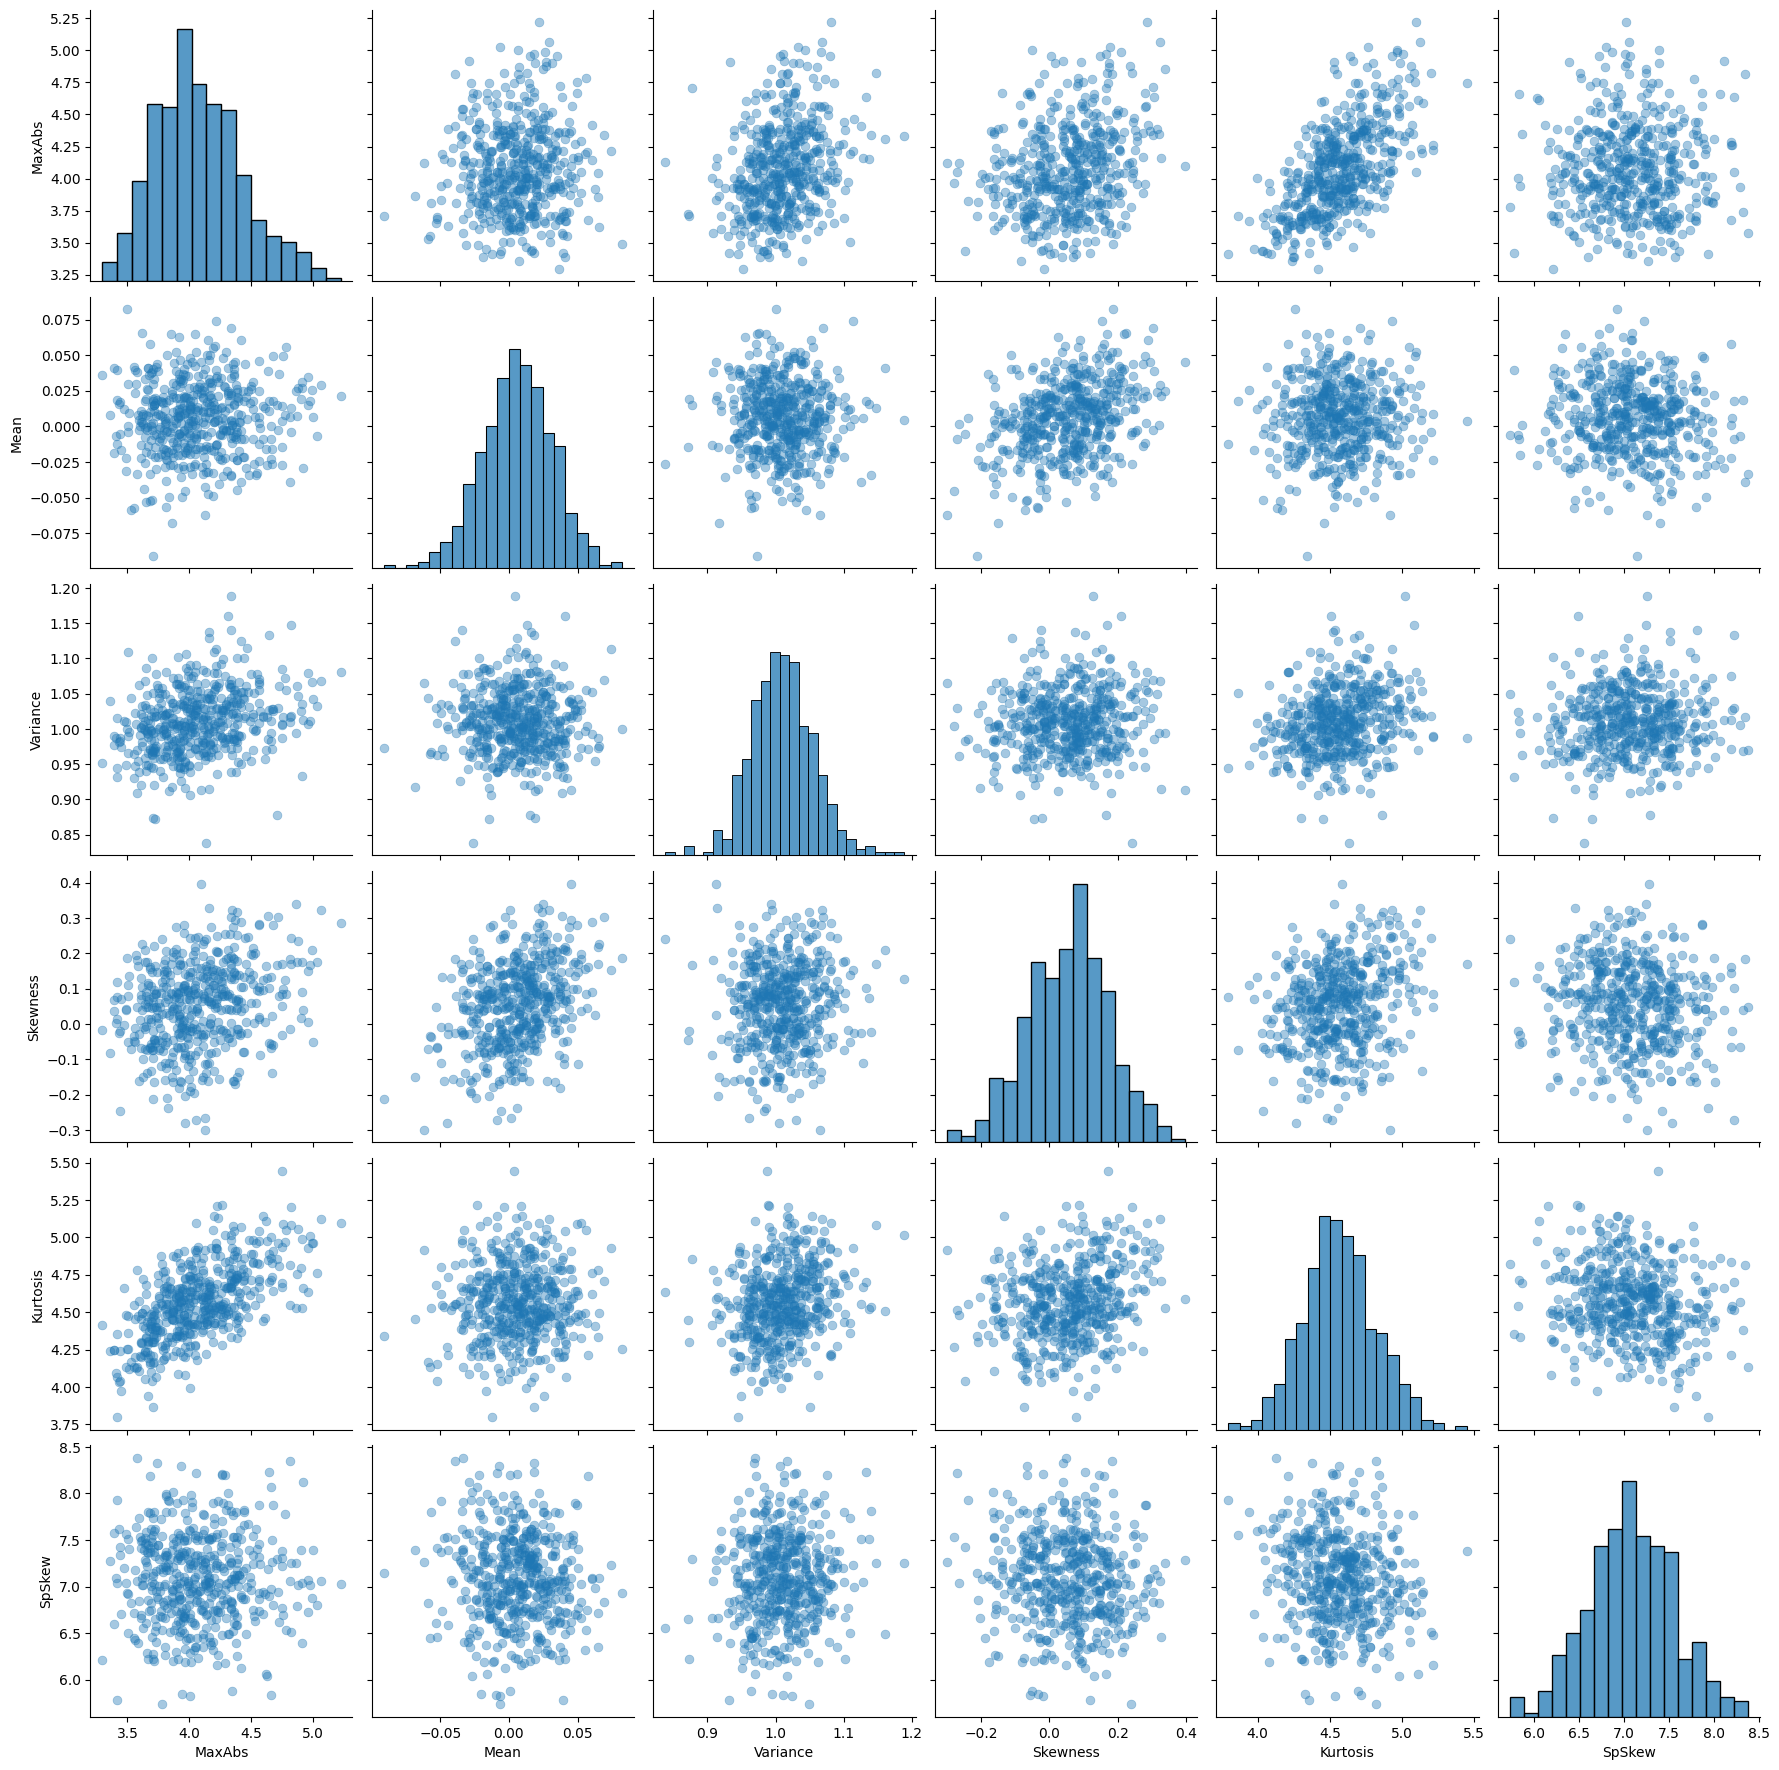

In [9]:
# If working on macOS, you want to specify that the diagonal plot should be histograms to avoid errors when plotting
# Otherwise you can leave the lines commented
sns.pairplot(
    train_moments,
    vars=[c for c in train_moments.columns if c != "type"],
    height=3,
    plot_kws={"alpha": 0.4, "s": 40, "edgecolor": None},
)
#            diag_kind = 'hist',
#           diag_kws = {'alpha': 0.4, 'log':True, 'density':True}
# )


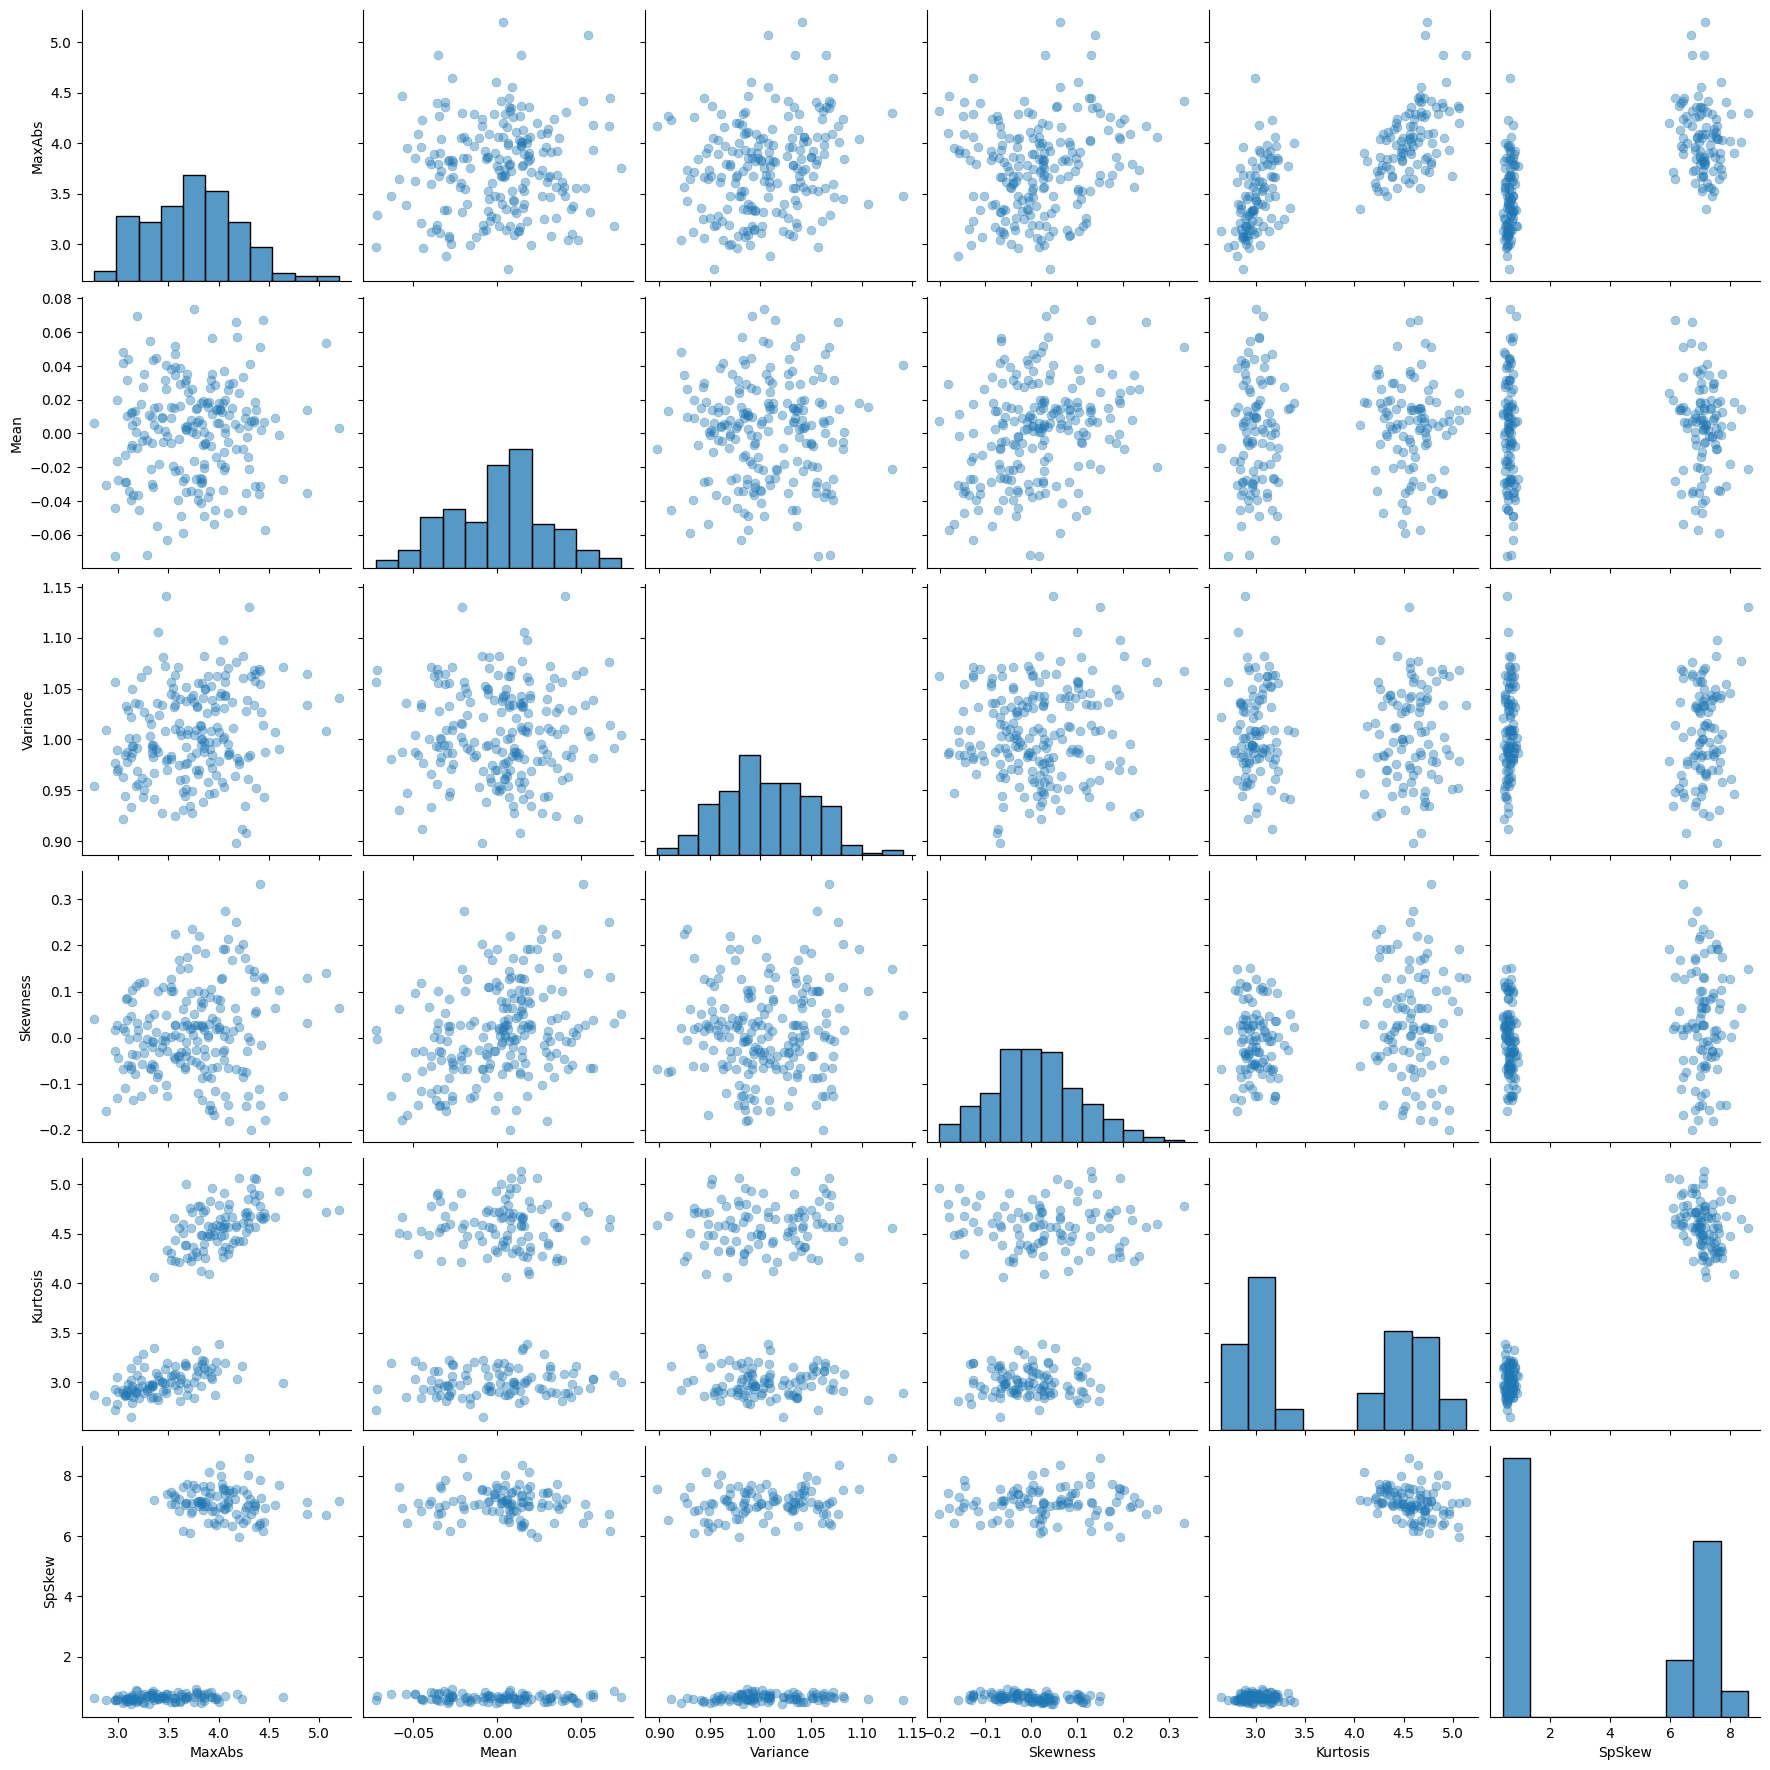

In [10]:
# If working on macOS, you want to specify that the diagonal plot should be histograms to avoid errors when plotting
# Otherwise you can leave the lines commented
sns.pairplot(
    test_moments,

    vars=[c for c in test_moments.columns if c != "type"],

    height=3,

    plot_kws={"alpha": 0.4, "s": 40, "edgecolor": None},
)
# ,
#            diag_kind = 'hist',
#           diag_kws = {'alpha': 0.4, 'log':True, 'density':True})


### 7. Defining thresholds based on normal data percentiles

Here, we define an anomaly detection rule based on thresholds, corresponding to the [0.5, 99.5] percentiles of the feature distributions of normal samples. In other words, a feature higher than 99.5% or lower than 0.5% of the normal features is considered an anomaly. Using only normal samples to base the decision is motivated by the facts that:

1. Few anomalies are observed
2. We cannot observe every possible anomaly

Anomalies are outliers with respect to the normal data distribution.

Text(0, 0.5, 'Percentile')

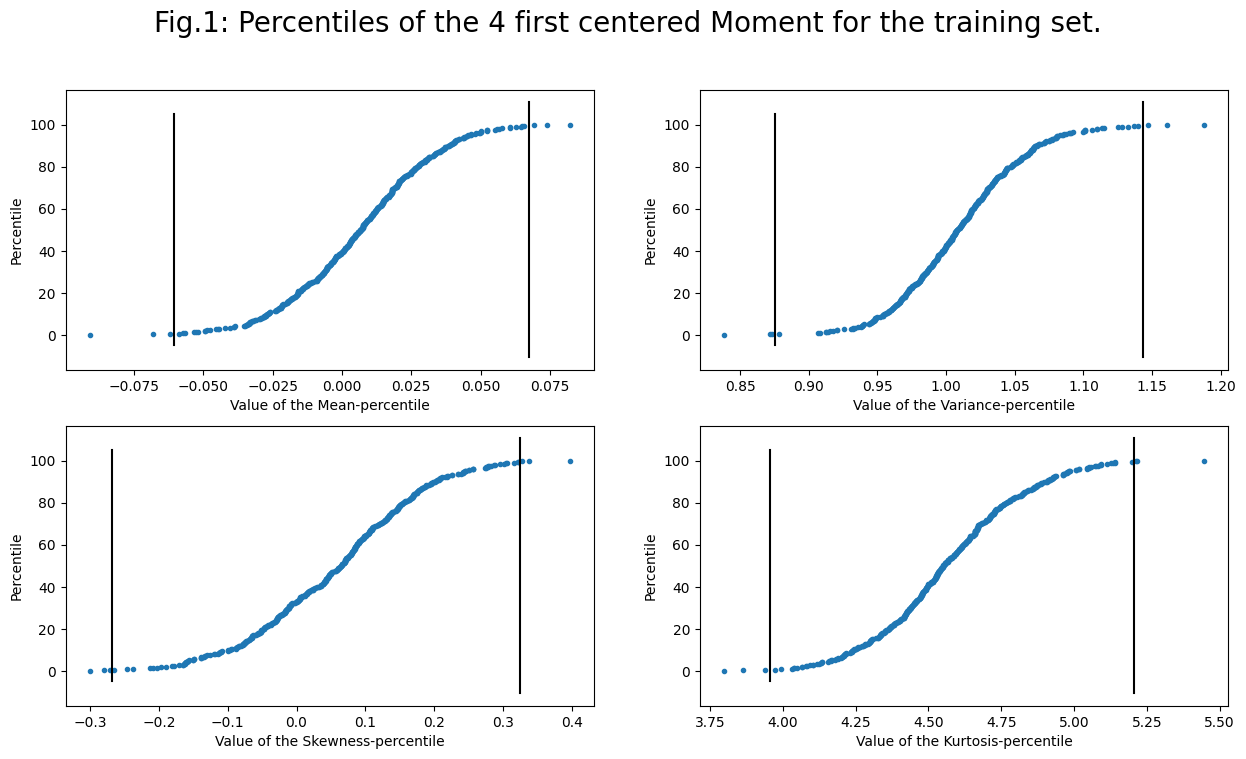

In [11]:
quantiles = [0.5, 99.5]
limit_max_abs = np.percentile(train_moments.loc[:, "MaxAbs"], quantiles)
limit_mean = np.percentile(train_moments.loc[:, "Mean"], quantiles)
limit_variance = np.percentile(train_moments.loc[:, "Variance"], quantiles)
lim_skew = np.percentile(train_moments.loc[:, "Skewness"], quantiles)
limit_kurtosis = np.percentile(train_moments.loc[:, "Kurtosis"], quantiles)
limit_sp_skew = np.percentile(train_moments.loc[:, "SpSkew"], quantiles)

train_percentage = np.linspace(0, 100, train_set_size)  # From 0% to 100%

plt.figure(1, figsize=(15, 8))
plt.clf()
plt.suptitle(
    "Fig.1: Percentiles of the 4 first centered Moment for the training set.",
    fontsize=20,
)
plt.subplot(2, 2, 1)
plt.plot(
    np.sort(train_moments.loc[:, "Mean"]), train_percentage, marker=".", linewidth=0
)
plt.plot([limit_mean[0], limit_mean[0]], plt.ylim(), color="k")
plt.plot([limit_mean[1], limit_mean[1]], plt.ylim(), color="k")
plt.xlabel("Value of the Mean-percentile")
plt.ylabel("Percentile")
plt.subplot(2, 2, 2)
plt.plot(
    np.sort(train_moments.loc[:, "Variance"]), train_percentage, marker=".", linewidth=0
)
plt.plot([limit_variance[0], limit_variance[0]], plt.ylim(), color="k")
plt.plot([limit_variance[1], limit_variance[1]], plt.ylim(), color="k")
plt.xlabel("Value of the Variance-percentile")
plt.ylabel("Percentile")
plt.subplot(2, 2, 3)
plt.plot(
    np.sort(train_moments.loc[:, "Skewness"]), train_percentage, marker=".", linewidth=0
)
plt.plot([lim_skew[0], lim_skew[0]], plt.ylim(), color="k")
plt.plot([lim_skew[1], lim_skew[1]], plt.ylim(), color="k")
plt.xlabel("Value of the Skewness-percentile")
plt.ylabel("Percentile")
plt.subplot(2, 2, 4)
plt.plot(
    np.sort(train_moments.loc[:, "Kurtosis"]), train_percentage, marker=".", linewidth=0
)
plt.plot([limit_kurtosis[0], limit_kurtosis[0]], plt.ylim(), color="k")
plt.plot([limit_kurtosis[1], limit_kurtosis[1]], plt.ylim(), color="k")
plt.xlabel("Value of the Kurtosis-percentile")
plt.ylabel("Percentile")


Text(0, 0.5, 'Percentile')

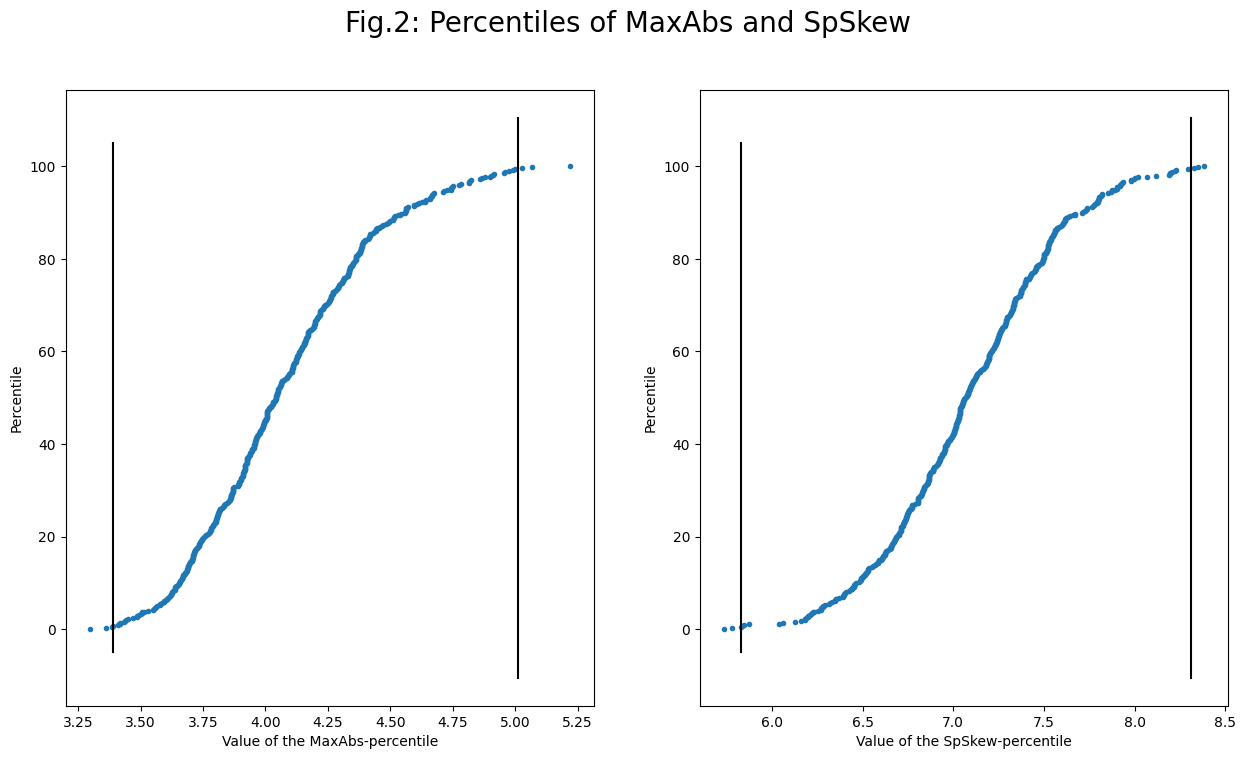

In [12]:
plt.figure(1, figsize=(15, 8))
plt.clf()
plt.suptitle("Fig.2: Percentiles of MaxAbs and SpSkew", fontsize=20)
plt.subplot(1, 2, 1)
plt.plot(np.sort(train_moments.loc[:, "MaxAbs"]), train_percentage, marker=".", linewidth=0)
plt.plot([limit_max_abs[0], limit_max_abs[0]], plt.ylim(), color="k")
plt.plot([limit_max_abs[1], limit_max_abs[1]], plt.ylim(), color="k")
plt.xlabel("Value of the MaxAbs-percentile")
plt.ylabel("Percentile")
plt.subplot(1, 2, 2)
plt.plot(np.sort(train_moments.loc[:, "SpSkew"]), train_percentage, marker=".", linewidth=0)
plt.plot([limit_sp_skew[0], limit_sp_skew[0]], plt.ylim(), color="k")
plt.plot([limit_sp_skew[1], limit_sp_skew[1]], plt.ylim(), color="k")
plt.xlabel("Value of the SpSkew-percentile")
plt.ylabel("Percentile")


Text(0, 0.5, 'Percentile')

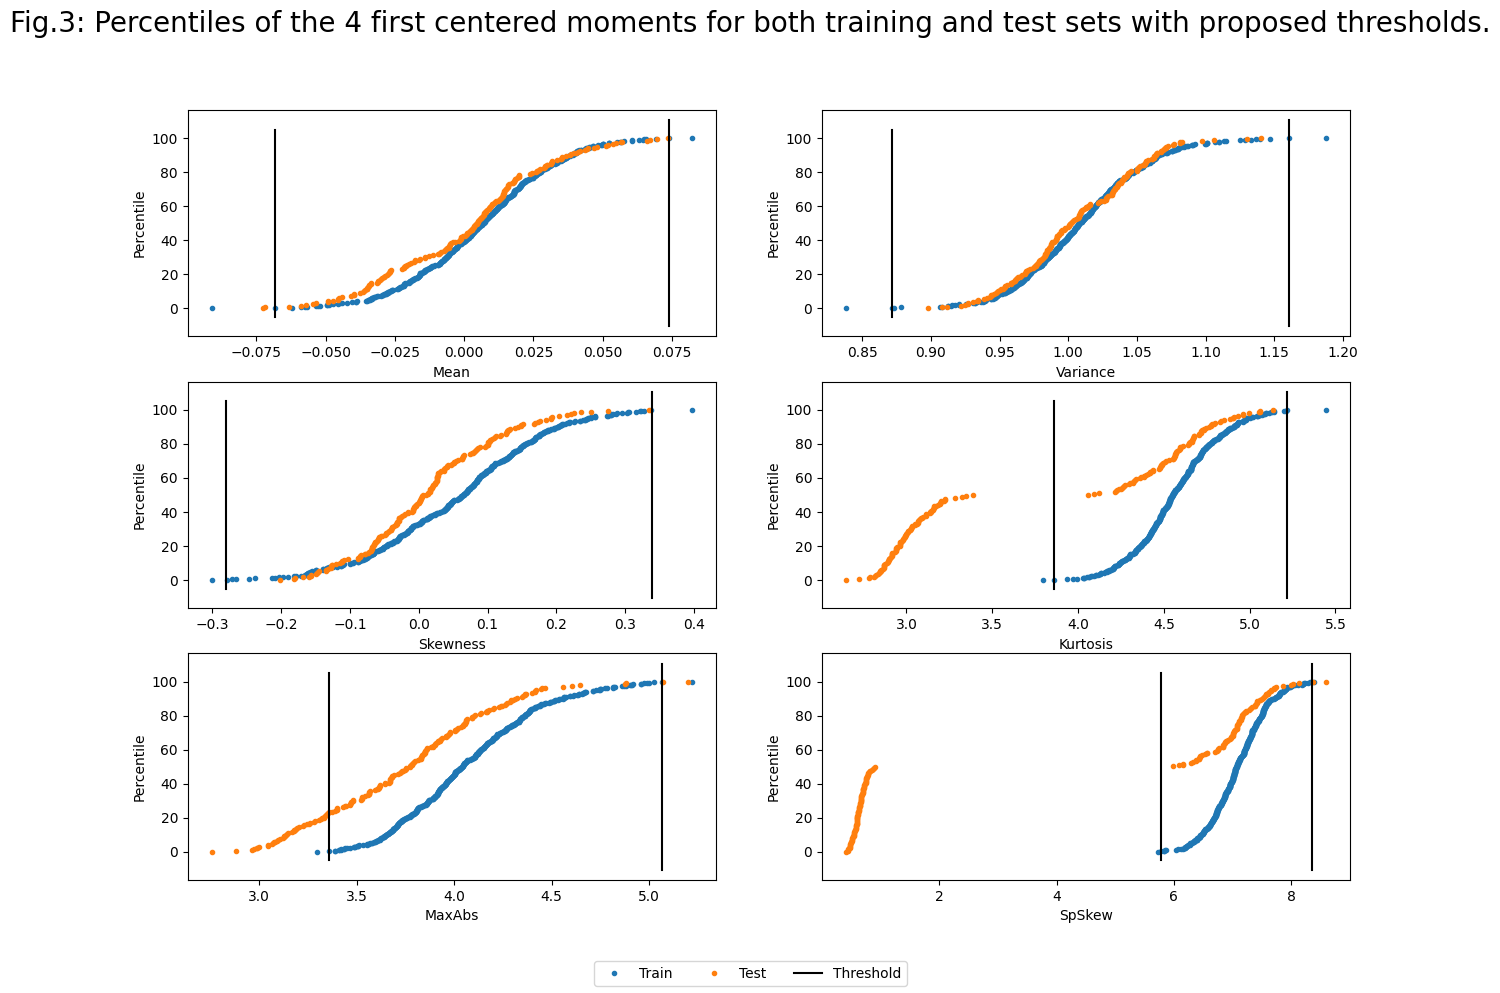

In [13]:
quantiles = [0.2, 99.8]
limit_max_abs = np.percentile(train_moments.loc[:, "MaxAbs"], quantiles)
limit_mean = np.percentile(train_moments.loc[:, "Mean"], quantiles)
limit_variance = np.percentile(train_moments.loc[:, "Variance"], quantiles)
lim_skew = np.percentile(train_moments.loc[:, "Skewness"], quantiles)
limit_kurtosis = np.percentile(train_moments.loc[:, "Kurtosis"], quantiles)
limit_sp_skew = np.percentile(train_moments.loc[:, "SpSkew"], quantiles)

test_percentage = np.linspace(0, 100, test_set_size)  # from 0% to 100% with step 100/nTrain

plt.figure(2, figsize=(15, 10))
plt.clf()
plt.suptitle(
    "Fig.3: Percentiles of the 4 first centered moments "
    + "for both training and test sets with proposed thresholds.",
    fontsize=20,
)
plt.subplot(3, 2, 1)
plt.plot(np.sort(train_moments.loc[:, "Mean"]), train_percentage, marker=".", linewidth=0)
plt.plot(np.sort(test_moments.loc[:, "Mean"]), test_percentage, marker=".", linewidth=0)
plt.plot([limit_mean[0], limit_mean[0]], plt.ylim(), color="k")
plt.plot([limit_mean[1], limit_mean[1]], plt.ylim(), color="k")
plt.xlabel("Mean")
plt.ylabel("Percentile")

plt.subplot(3, 2, 2)
plt.plot(np.sort(train_moments.loc[:, "Variance"]), train_percentage, marker=".", linewidth=0)
plt.plot(np.sort(test_moments.loc[:, "Variance"]), test_percentage, marker=".", linewidth=0)
plt.plot([limit_variance[0], limit_variance[0]], plt.ylim(), color="k")
plt.plot([limit_variance[1], limit_variance[1]], plt.ylim(), color="k")
plt.xlabel("Variance")
plt.ylabel("Percentile")

plt.subplot(3, 2, 3)
plt.plot(np.sort(train_moments.loc[:, "Skewness"]), train_percentage, marker=".", linewidth=0)
plt.plot(np.sort(test_moments.loc[:, "Skewness"]), test_percentage, marker=".", linewidth=0)
plt.plot([lim_skew[0], lim_skew[0]], plt.ylim(), color="k")
plt.plot([lim_skew[1], lim_skew[1]], plt.ylim(), color="k")
plt.xlabel("Skewness")
plt.ylabel("Percentile")
# plt.xlim([-50,50])

plt.subplot(3, 2, 4)
plt.plot(np.sort(train_moments.loc[:, "Kurtosis"]), train_percentage, marker=".", linewidth=0)
plt.plot(np.sort(test_moments.loc[:, "Kurtosis"]), test_percentage, marker=".", linewidth=0)
plt.plot([limit_kurtosis[0], limit_kurtosis[0]], plt.ylim(), color="k")
plt.plot([limit_kurtosis[1], limit_kurtosis[1]], plt.ylim(), color="k")
plt.xlabel("Kurtosis")
plt.ylabel("Percentile")
# plt.xlim([-50,5000])
plt.figlegend(
    ["Train", "Test", "Threshold"], loc="lower center", ncol=5, labelspacing=0.0
)

plt.subplot(3, 2, 5)
plt.plot(np.sort(train_moments.loc[:, "MaxAbs"]), train_percentage, marker=".", linewidth=0)
plt.plot(np.sort(test_moments.loc[:, "MaxAbs"]), test_percentage, marker=".", linewidth=0)
plt.plot([limit_max_abs[0], limit_max_abs[0]], plt.ylim(), color="k")
plt.plot([limit_max_abs[1], limit_max_abs[1]], plt.ylim(), color="k")
plt.xlabel("MaxAbs")
plt.ylabel("Percentile")

plt.subplot(3, 2, 6)
plt.plot(np.sort(train_moments.loc[:, "SpSkew"]), train_percentage, marker=".", linewidth=0)
plt.plot(np.sort(test_moments.loc[:, "SpSkew"]), test_percentage, marker=".", linewidth=0)
plt.plot([limit_sp_skew[0], limit_sp_skew[0]], plt.ylim(), color="k")
plt.plot([limit_sp_skew[1], limit_sp_skew[1]], plt.ylim(), color="k")
plt.xlabel("SpSkew")
plt.ylabel("Percentile")


In [14]:
# select points either below 0.5 percentile or above 99.5 percentile of each moments and min-max limits
abn_train_mean = np.where(
    (train_moments.loc[:, "Mean"] < limit_mean[0])
    | (train_moments.loc[:, "Mean"] > limit_mean[1])
)[0]
abn_train_variance = np.where(
    (train_moments.loc[:, "Variance"] < limit_variance[0])
    | (train_moments.loc[:, "Variance"] > limit_variance[1])
)[0]
abn_train_skew = np.where(
    (train_moments.loc[:, "Skewness"] < lim_skew[0])
    | (train_moments.loc[:, "Skewness"] > lim_skew[1])
)[0]
abn_train_kurtosis = np.where(
    (train_moments.loc[:, "Kurtosis"] < limit_kurtosis[0])
    | (train_moments.loc[:, "Kurtosis"] > limit_kurtosis[1])
)[0]

abn_train_max_abs = np.where(
    (train_moments.loc[:, "MaxAbs"] < limit_max_abs[0])
    | (train_moments.loc[:, "MaxAbs"] > limit_max_abs[1])
)[0]
abn_train_sp_skew = np.where(
    (train_moments.loc[:, "SpSkew"] < limit_sp_skew[0])
    | (train_moments.loc[:, "SpSkew"] > limit_sp_skew[1])
)[0]

all_abnormalities_train = np.unique(
    np.concatenate(
        (
            abn_train_mean,
            abn_train_variance,
            abn_train_skew,
            abn_train_kurtosis,
            abn_train_max_abs,
            abn_train_sp_skew,
        )
    )
)

# Compare sets together. Loop over each pair of sets and compute how many IDs they have in common
train_dict = {
    "Mean": abn_train_mean,
    "Variance": abn_train_variance,
    "Skewness": abn_train_skew,
    "Kurtsosis": abn_train_kurtosis,
    "MaxAbs": abn_train_max_abs,
    "SpSkew": abn_train_sp_skew,
}
train_dict_keys = list(train_dict.keys())

print("TRAINING DATASET")
for i in range(train_dict.__len__()):
    k1 = train_dict_keys[i]
    print("{}: {} anomalies found.".format(k1, train_dict[k1].__len__()))

anomalies_count_train = np.array(
    [np.sum([i in train_dict[k] for k in train_dict]) for i in range(train_set_size)]
)
for i in range(1, 5):
    print(
        "{} samples are found as anomalous by at least {} selection methods.".format(
            len(np.where(anomalies_count_train >= i)[0]), i
        )
    )

######################################################################################################

# select points either below 0.2 percentile or above 99.8 percentile of each moments and min-max limits
abn_test_mean = np.where(
    (test_moments.loc[:, "Mean"] < limit_mean[0])
    | (test_moments.loc[:, "Mean"] > limit_mean[1])
)[0]
abn_test_variance = np.where(
    (test_moments.loc[:, "Variance"] < limit_variance[0])
    | (test_moments.loc[:, "Variance"] > limit_variance[1])
)[0]
abn_test_skew = np.where(
    (test_moments.loc[:, "Skewness"] < lim_skew[0])
    | (test_moments.loc[:, "Skewness"] > lim_skew[1])
)[0]
abn_test_kurtosis = np.where(
    (test_moments.loc[:, "Kurtosis"] < limit_kurtosis[0])
    | (test_moments.loc[:, "Kurtosis"] > limit_kurtosis[1])
)[0]

abn_test_max_abs = np.where(
    (test_moments.loc[:, "MaxAbs"] < limit_max_abs[0])
    | (test_moments.loc[:, "MaxAbs"] > limit_max_abs[1])
)[0]
abn_test_sp_skew = np.where(
    (test_moments.loc[:, "SpSkew"] < limit_sp_skew[0])
    | (test_moments.loc[:, "SpSkew"] > limit_sp_skew[1])
)[0]

allAbnormalities = np.unique(
    np.concatenate(
        (
            abn_test_mean,
            abn_test_variance,
            abn_test_skew,
            abn_test_kurtosis,
            abn_test_max_abs,
            abn_test_sp_skew,
        )
    )
)


# compare sets together. Here I loop over each pair of set and compute how many ID they have in common
test_dict = {
    "Mean": abn_test_mean,
    "Variance": abn_test_variance,
    "Skewness": abn_test_skew,
    "Kurtosis": abn_test_kurtosis,
    "MaxAbs": abn_test_max_abs,
    "SpSkew": abn_test_sp_skew,
}
keysTest = list(test_dict.keys())


print("\nTEST DATASET")
for ii in range(test_dict.__len__()):
    k1 = keysTest[ii]
    print(f"{k1}: {len(test_dict[k1])} anomalies found.")

countAbnormalTest = np.array(
    [np.sum([i in test_dict[k] for k in test_dict]) for i in range(test_set_size)]
)
for i in range(1, 5):
    print(
        f"{len(np.where(countAbnormalTest >= i)[0])} samples are found as anomalous "
        f"by at least {i} selection methods."
    )


TRAINING DATASET
Mean: 2 anomalies found.
Variance: 2 anomalies found.
Skewness: 2 anomalies found.
Kurtsosis: 2 anomalies found.
MaxAbs: 2 anomalies found.
SpSkew: 2 anomalies found.
12 samples are found as anomalous by at least 1 selection methods.
0 samples are found as anomalous by at least 2 selection methods.
0 samples are found as anomalous by at least 3 selection methods.
0 samples are found as anomalous by at least 4 selection methods.

TEST DATASET
Mean: 2 anomalies found.
Variance: 0 anomalies found.
Skewness: 0 anomalies found.
Kurtosis: 100 anomalies found.
MaxAbs: 48 anomalies found.
SpSkew: 102 anomalies found.
105 samples are found as anomalous by at least 1 selection methods.
100 samples are found as anomalous by at least 2 selection methods.
45 samples are found as anomalous by at least 3 selection methods.
2 samples are found as anomalous by at least 4 selection methods.


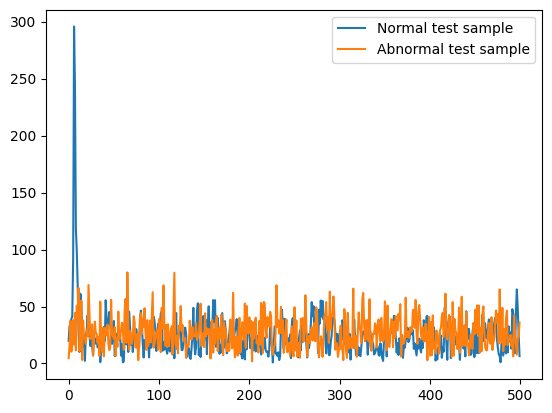

In [15]:
fft = np.abs(np.fft.fft(train_set[1]))[: train_set_timesteps // 2]
plt.plot(fft, label="Normal test sample")
fft = np.abs(np.fft.fft(test_set[0]))[: test_set_timesteps // 2]
plt.plot(fft, label="Abnormal test sample")
plt.legend()


Text(0.5, 1.0, 'Test dataset')

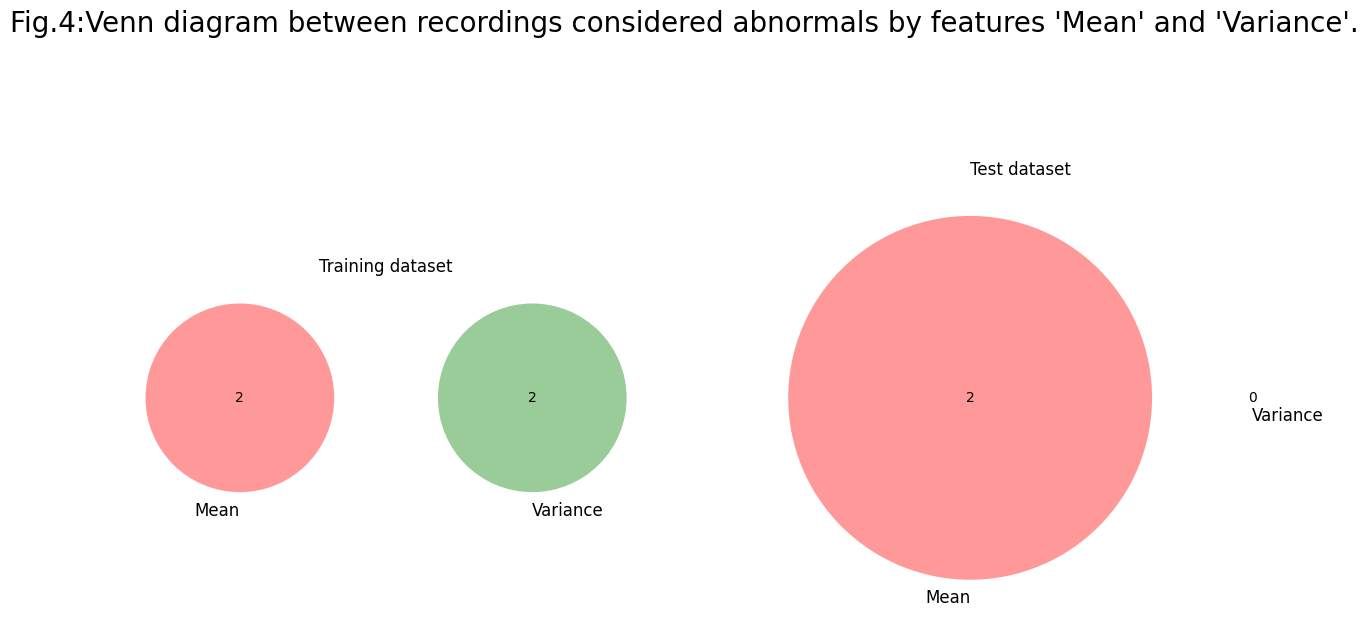

In [16]:
plt.figure(3, figsize=(15, 8))
plt.clf()
plt.suptitle(
    "Fig.4:Venn diagram between recordings considered abnormals by features 'Mean' and 'Variance'.",
    fontsize=20,
)

loc_train_mean = (train_moments.loc[:, "Mean"] < limit_mean[0]) | (
    train_moments.loc[:, "Mean"] > limit_mean[1]
)
loc_train_variance = (train_moments.loc[:, "Variance"] < limit_variance[0]) | (
    train_moments.loc[:, "Variance"] > limit_variance[1]
)
a1 = np.sum(loc_train_mean & loc_train_variance)
a2 = np.sum(loc_train_mean & ~loc_train_variance)
a3 = np.sum(~loc_train_mean & loc_train_variance)

plt.subplot(121)
venn2(subsets=(a2, a3, a1), set_labels=("Mean", "Variance"))
plt.title("Training dataset")


loc_test_mean = (test_moments.loc[:, "Mean"] < limit_mean[0]) | (
    test_moments.loc[:, "Mean"] > limit_mean[1]
)
loc_test_variance = (test_moments.loc[:, "Variance"] < limit_variance[0]) | (
    test_moments.loc[:, "Variance"] > limit_variance[1]
)
a1 = np.sum(loc_test_mean & loc_test_variance)
a2 = np.sum(loc_test_mean & ~loc_test_variance)
a3 = np.sum(~loc_test_mean & loc_test_variance)


plt.subplot(122)
venn2(subsets=(a2, a3, a1), set_labels=("Mean", "Variance"))
plt.title("Test dataset")


Text(0.5, 1.0, 'Test dataset')

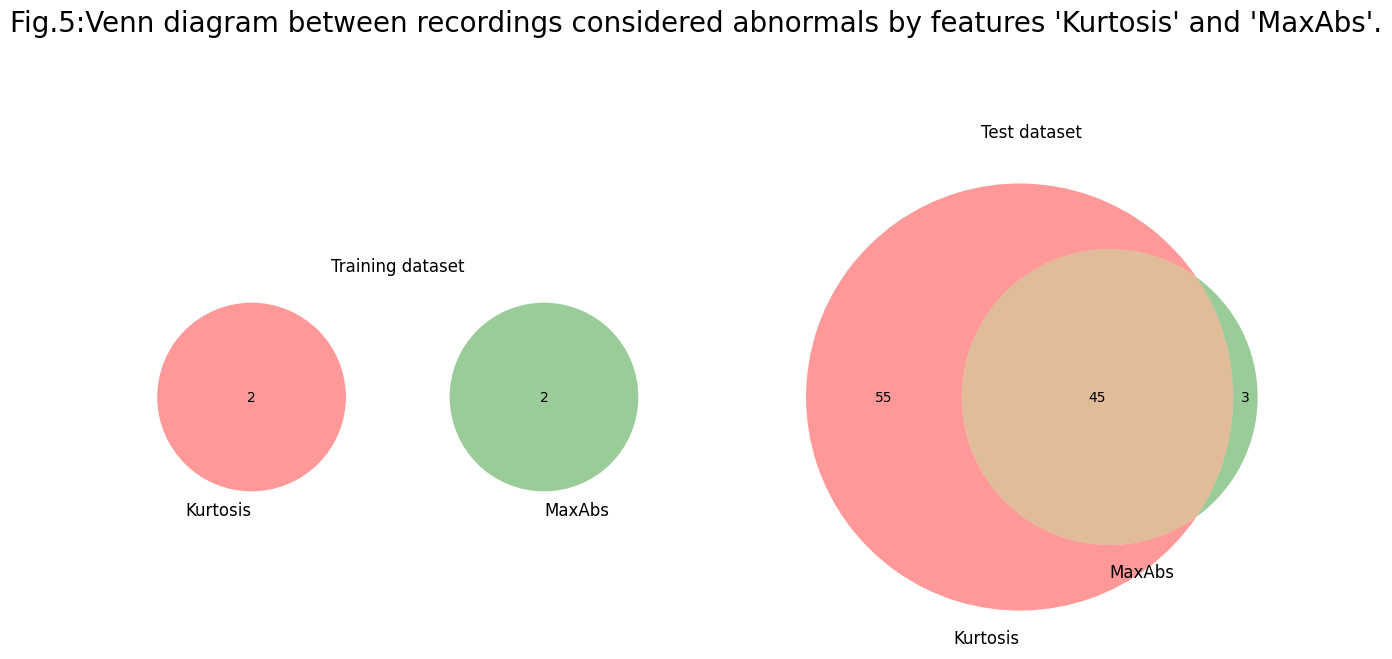

In [17]:
plt.figure(3, figsize=(15, 8))
plt.clf()
plt.suptitle(
    "Fig.5:Venn diagram between recordings considered abnormals by features 'Kurtosis' and 'MaxAbs'.",
    fontsize=20,
)

loc_train_kurtosis = (train_moments.loc[:, "Kurtosis"] < limit_kurtosis[0]) | (
    train_moments.loc[:, "Kurtosis"] > limit_kurtosis[1]
)
loc_train_max_abs = (train_moments.loc[:, "MaxAbs"] < limit_max_abs[0]) | (
    train_moments.loc[:, "MaxAbs"] > limit_max_abs[1]
)
a1 = np.sum(loc_train_kurtosis & loc_train_max_abs)
a2 = np.sum(loc_train_kurtosis & ~loc_train_max_abs)
a3 = np.sum(~loc_train_kurtosis & loc_train_max_abs)

plt.subplot(121)
venn2(subsets=(a2, a3, a1), set_labels=("Kurtosis", "MaxAbs"))
plt.title("Training dataset")


loc_test_kurtosis = (test_moments.loc[:, "Kurtosis"] < limit_kurtosis[0]) | (
    test_moments.loc[:, "Kurtosis"] > limit_kurtosis[1]
)
loc_test_max_abs = (test_moments.loc[:, "MaxAbs"] < limit_max_abs[0]) | (
    test_moments.loc[:, "MaxAbs"] > limit_max_abs[1]
)
a1 = np.sum(loc_test_kurtosis & loc_test_max_abs)
a2 = np.sum(loc_test_kurtosis & ~loc_test_max_abs)
a3 = np.sum(~loc_test_kurtosis & loc_test_max_abs)


plt.subplot(122)
venn2(subsets=(a2, a3, a1), set_labels=("Kurtosis", "MaxAbs"))
plt.title("Test dataset")


Text(0.5, 1.0, 'Test dataset')

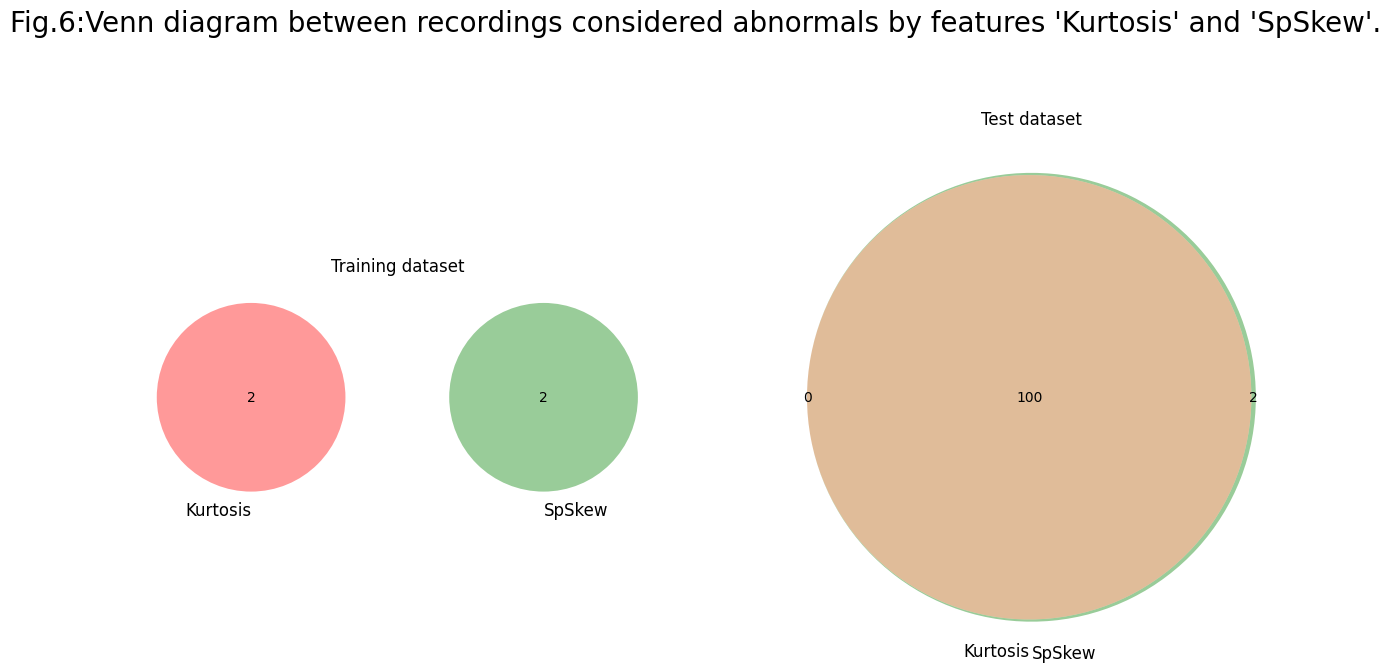

In [18]:
plt.figure(3, figsize=(15, 8))
plt.clf()
plt.suptitle(
    "Fig.6:Venn diagram between recordings considered abnormals by features 'Kurtosis' and 'SpSkew'.",
    fontsize=20,
)

loc_train_kurtosis = (train_moments.loc[:, "Kurtosis"] < limit_kurtosis[0]) | (
    train_moments.loc[:, "Kurtosis"] > limit_kurtosis[1]
)
loc_train_sp_skew = (train_moments.loc[:, "SpSkew"] < limit_sp_skew[0]) | (
    train_moments.loc[:, "SpSkew"] > limit_sp_skew[1]
)
a1 = np.sum(loc_train_kurtosis & loc_train_sp_skew)
a2 = np.sum(loc_train_kurtosis & ~loc_train_sp_skew)
a3 = np.sum(~loc_train_kurtosis & loc_train_sp_skew)

plt.subplot(121)
venn2(subsets=(a2, a3, a1), set_labels=("Kurtosis", "SpSkew"))
plt.title("Training dataset")


loc_test_kurtosis = (test_moments.loc[:, "Kurtosis"] < limit_kurtosis[0]) | (
    test_moments.loc[:, "Kurtosis"] > limit_kurtosis[1]
)
loc_test_sp_skew = (test_moments.loc[:, "SpSkew"] < limit_sp_skew[0]) | (
    test_moments.loc[:, "SpSkew"] > limit_sp_skew[1]
)
a1 = np.sum(loc_test_kurtosis & loc_test_sp_skew)
a2 = np.sum(loc_test_kurtosis & ~loc_test_sp_skew)
a3 = np.sum(~loc_test_kurtosis & loc_test_sp_skew)


plt.subplot(122)
venn2(subsets=(a2, a3, a1), set_labels=("Kurtosis", "SpSkew"))
plt.title("Test dataset")


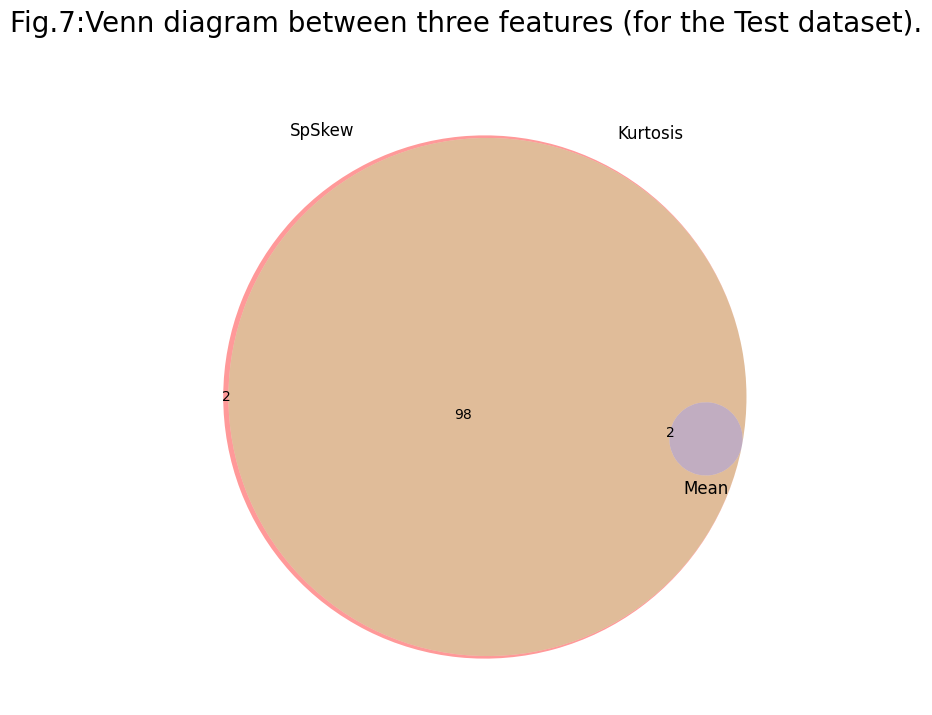

In [19]:
loc_test_kurtosis = (test_moments.loc[:, "Kurtosis"] < limit_kurtosis[0]) | (
    test_moments.loc[:, "Kurtosis"] > limit_kurtosis[1]
)
loc_test_mean = (test_moments.loc[:, "Mean"] < limit_mean[0]) | (
    test_moments.loc[:, "Mean"] > limit_mean[1]
)
loc_test_sp_skew = (test_moments.loc[:, "SpSkew"] < limit_sp_skew[0]) | (
    test_moments.loc[:, "SpSkew"] > limit_sp_skew[1]
)

a1 = np.sum((loc_test_sp_skew & ~loc_test_kurtosis) & ~loc_test_mean)
a2 = np.sum((~loc_test_sp_skew & loc_test_kurtosis) & ~loc_test_mean)
a3 = np.sum((loc_test_sp_skew & loc_test_kurtosis) & ~loc_test_mean)
a4 = np.sum((~loc_test_sp_skew & ~loc_test_kurtosis) & loc_test_mean)
a5 = np.sum((loc_test_sp_skew & ~loc_test_kurtosis) & loc_test_mean)
a6 = np.sum((~loc_test_sp_skew & loc_test_kurtosis) & loc_test_mean)
a7 = np.sum((loc_test_sp_skew & loc_test_kurtosis) & loc_test_mean)

plt.figure(4, figsize=(15, 8))
plt.clf()
plt.suptitle(
    "Fig.7:Venn diagram between three features (for the Test dataset).", fontsize=20
)

venn3(subsets=(a1, a2, a3, a4, a5, a6, a7), set_labels=("SpSkew", "Kurtosis", "Mean"))


---

## Part 1: Exercise

⚠️ **This part contains the actual graded exercise 1 questions.** ⚠️

Find your own features for a real acoustic dataset from industrial machines!

Acoustic emission and vibration monitoring play integral roles in structural health 
monitoring (SHM) by providing crucial insights into the condition and integrity of 
structures. Acoustic Emission involves the detection of transient stress waves or 
acoustic signals emitted by materials when they undergo deformation or damage. Vibration 
monitoring with accelerometers is widely used to assess the structural integrity of 
various systems, from bridges and buildings to rotating machinery. Vibration analysis 
can reveal changes in natural frequencies, mode shapes, and damping characteristics, 
which can be indicative of structural damage or degradation. 

### Dataset Description

For this exercise, we consider acoustic emissions from two machines: a **pump** and a 
**valve**. The datasets come as follows:

* **pump**
    * train set containing data from pump in good working conditions
    * test set containing both healthy data and data from pumps with abnormal behaviors
* **valve**
    * train set containing data from valve in good working conditions
    * test set containing both healthy data and data from valves with abnormal behaviors

### Problem Description

Using features introduced in [Part 0](#part-0-demonstration), other features presented 
during lectures and previous exercises, or any other features you deem useful, your goal
is to identify features that can uncover anomalies present in the test dataset but not 
present in the training dataset. Selected features will be different for the pump and 
valve.

### Questions

**Question 1:** Generate plots of raw signals, FFT spectrums or spectrogram from the 
healthy data of both the pump and valve acoustic signals. Discuss the distinctions 
between the signals emitted by these two machines.

Questions 2, 3 and 4 have to be answered separately for both the pump and valve datasets.

**Question 2:** Visualize the raw signals, spectrum, and spectrograms of the test 
dataset for the pump/valve dataset. Are there any signals that appear abnormal to you?

**Question 3:** Compute basic statistical features (mean, variance, skewness, and 
kurtosis) for both the training and test datasets of the pump and valve. Are there any 
abnormal signals that you can detect?

**Question 4:** Find by yourself a feature or a combination of feature that help to 
uncover signals with abnormal behavior. Analyze whether the selected features trigger 
alarms for similar behavior or if some are specific to particular anomalies.

**Question 5:** What are some potential limitations of the method suggested in this 
exercise for anomaly detection? Answer with at least 3 limitations.

**Question 6:** Now that you have developed a set of features and thresholds for a 
valve/pump, imagine applying them to a different valve/pump. Would the discriminative 
power change? If so, how do you propose to mitigate it? Justify and provide concrete 
details.

**Question 7:** Now imagine you're in a scenario where the are no anomalous samples 
available. How would you tackle this problem? Answer with an overview of your proposed 
approach and then provide concrete details regarding the method.


The answers to those questions are expected in a **PDF report**. The full Jupyter notebook 
must also be submitted. A PDF report without any description, analysis, and discussion 
around the plots will not be considered valid.

### Critical Points & Requirements

Here is a unorded non-exhaustive list of some critical points which will be taken into 
account for grading:
- Quality of the plots (legend, axes labels, plot titles, units, ...)
- Discriminative power of the selected features (performance) on the `valve` dataset
- Discriminative power of the selected features (performance) on the `pump` dataset
- Quality of the scientific reasoning
- Structure, clarity, and conciseness of the report
- Quality of the code (useful but concise documentation, clarity of the code, ...)
- ...

⚠️ Your submitted notebook should be able to run on a properly configured environment
(*c.f.* week 1 exercises). If you require additional packages, make sure to add a 
`pip install` command in a code cell (example in the following cell to install `gdown`.)

### 0. Download the Dataset

``gdown`` is a Python library and command-line tool that simplifies the process of downloading files from Google Drive.

In [20]:
%pip install gdown --upgrade --quiet
import gdown


Note: you may need to restart the kernel to use updated packages.


In [21]:
# Pump dataset
gdown.download(id="1Vz1fhpu5xKJ4RI5maJh_3OweX9BpjBaM", output="./pump.zip")


Downloading...
From (original): https://drive.google.com/uc?id=1Vz1fhpu5xKJ4RI5maJh_3OweX9BpjBaM
From (redirected): https://drive.google.com/uc?id=1Vz1fhpu5xKJ4RI5maJh_3OweX9BpjBaM&confirm=t&uuid=da80e5a9-c51d-42a2-b7af-35c5fcb5217f
To: /Users/sopheabonnne/EPFL/CIVIL-426/ml4pm/pump.zip
100%|██████████| 100M/100M [00:07<00:00, 13.3MB/s] 


'./pump.zip'

In [22]:
# Valve dataset
gdown.download(id="13bzdjL0gEc9hsGHjr0Qo8OMcMF5CrYbS", output="./valve.zip")


Downloading...
From (original): https://drive.google.com/uc?id=13bzdjL0gEc9hsGHjr0Qo8OMcMF5CrYbS
From (redirected): https://drive.google.com/uc?id=13bzdjL0gEc9hsGHjr0Qo8OMcMF5CrYbS&confirm=t&uuid=408793da-a02e-4419-a91b-096fc86aa7c2
To: /Users/sopheabonnne/EPFL/CIVIL-426/ml4pm/valve.zip
100%|██████████| 177M/177M [00:09<00:00, 18.4MB/s] 


'./valve.zip'

### 1. Extract the Datasets

In [23]:
import zipfile
import os

# List all ZIP files in the current directory
zip_files = [file for file in os.listdir() if file.endswith(".zip")]

# Loop through each ZIP file and unzip it in the same directory
for zip_file in zip_files:
    with zipfile.ZipFile(zip_file, "r") as zip_ref:
        zip_ref.extractall()


### 2. Load the Audio Data

In this code cell, we are using the `librosa` library to load audio files from two 
directories: `/valve` and `/pump`. The goal is to prepare audio data for further 
analysis or processing.


In [24]:
def load_wav_files(directory: str) -> np.ndarray:
    """Load all .WAV audio files in a directory as a 2D Numpy array

    Args:
        directory (str): Path to the directory containing the audio files

    Returns:
        np.ndarray: Loaded audio files as a 2D array
    """
    audio_data: list = []

    # Iterate through files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".wav") or filename.endswith(".WAV"):
            file_path = os.path.join(directory, filename)

            # Load audio file and append it to the list
            audio, sr = librosa.load(file_path, sr=None)
            audio_data.append(audio)

    return np.array(audio_data)


# Paths to the "valve" and "pump" directories
valve_directory = "./valve"
pump_directory = "./pump"

# Load audio data for "valve" and "pump"
valve_train_data = load_wav_files(os.path.join(valve_directory, "train"))
valve_test_data = load_wav_files(os.path.join(valve_directory, "test"))
pump_train_data = load_wav_files(os.path.join(pump_directory, "train"))
pump_test_data = load_wav_files(os.path.join(pump_directory, "test"))


In [25]:
print(f"Valve Train Data Shape: {valve_train_data.shape}")
print(f"Valve Test Data Shape: {valve_test_data.shape}")
print(f"Pump Train Data Shape: {pump_train_data.shape}")
print(f"Pump Test Data Shape: {pump_test_data.shape}")


Valve Train Data Shape: (500, 160000)
Valve Test Data Shape: (219, 160000)
Pump Train Data Shape: (200, 160000)
Pump Test Data Shape: (200, 160000)


⚠️ **You're expected to fill the notebook from here.** ⚠️

### Question 1:


In [26]:
# Add all your necessary code to answer question 1


### Question 2:

In [27]:
# Add all your necessary code to answer question 2


### Question 3:

In [28]:
# Add all your necessary code to answer question 3


### Question 4:

In [29]:
# Add all your necessary code to answer question 4
